# Social dimension (Who)
* Misinformation detection exploiting user features
* Detection of malicious users: can we distinguish malicious from gullible users?
* Detection of superspreaders: abnormal rates of misinformation spread
* Detection of sources of misinformation: first users to share misinformation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from utils import preprocess
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from gensim.models import Word2Vec

%matplotlib inline
sns.set(style="darkgrid")

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Create user data

In [2]:
# df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
# def custom_time(data,hora):
#     string = data + " " + hora
#     return string
# df['timestamp'] = df.apply(lambda x: custom_time(x['date'],x['hour']),axis=1)
# df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
# df.sort_values(by='timestamp',inplace=True)
# df_users = utils.get_top_users(df,top=None)
# df_users.to_csv('data/2018/users.csv', index=False)

In [3]:
df_users.columns

NameError: name 'df_users' is not defined

In [ ]:
df_users.sort_values('viral_ratio',ascending=False)

In [9]:
df_users[['groups', 'number_of_messages', 'texts', 'midia',
       'virals', 'repeated_messages','misinformation']].describe().round(2)

,groups,number_of_messages,texts,midia,virals,repeated_messages,misinformation
count,5364.00,5364.00,5364.00,5364.00,5364.00,5364.00,5364.00
mean,1.16,52.68,29.13,23.55,3.89,2.57,2.13
std,0.65,138.06,89.74,63.19,15.01,16.26,7.33
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,3.00,2.00,1.00,0.00,0.00,0.00
50%,1.00,13.00,6.00,4.00,0.00,0.00,0.00
75%,1.00,45.00,23.00,19.00,2.00,1.00,1.00
max,11.00,4396.00,3742.00,1360.00,564.00,609.00,147.00


In [10]:
df_users[['text_ratio', 'midia_ratio', 'viral_ratio', 
          'repeated_messages_ratio', 'misinformation_ratio']].describe().round(3)

,text_ratio,midia_ratio,viral_ratio,repeated_messages_ratio,misinformation_ratio
count,5364.000,5364.000,5364.000,5364.000,5364.000
mean,0.567,0.433,0.069,0.039,0.041
std,0.317,0.317,0.140,0.107,0.107
min,0.000,0.000,0.000,0.000,0.000
25%,0.333,0.158,0.000,0.000,0.000
50%,0.571,0.429,0.000,0.000,0.000
75%,0.842,0.667,0.085,0.014,0.042
max,1.000,1.000,1.000,0.941,1.000


In [11]:
df_users[['days_active', 'daily_mean', 'daily_std',
       'daily_median', 'daily_max']].describe().round(3)

,days_active,daily_mean,daily_std,daily_median,daily_max
count,5364.000,5364.000,4217.000,5364.000,5364.000
mean,33.325,2.109,2.778,1.370,10.254
std,30.040,5.032,4.657,4.838,16.857
min,1.000,0.028,0.000,0.000,1.000
25%,3.000,0.404,0.707,0.000,2.000
50%,28.000,1.000,1.421,0.000,4.000
75%,59.000,2.000,3.182,1.000,12.000
max,120.000,149.000,148.492,149.000,294.000


In [14]:
df_users[['degree_centrality', 'strenght', 'viral_degree_centrality',
       'viral_strenght', 'misinformation_degree_centrality',
       'misinformation_strenght']].describe().round(0)



,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformation_degree_centrality,misinformation_strenght
count,5364.0,5364.0,5364.0,5364.0,5364.0,5364.0
mean,215.0,10598.0,105.0,713.0,83.0,386.0
std,142.0,29226.0,151.0,2859.0,136.0,1392.0
min,3.0,7.0,0.0,0.0,0.0,0.0
25%,105.0,494.0,0.0,0.0,0.0,0.0
50%,200.0,2114.0,0.0,0.0,0.0,0.0
75%,278.0,8322.0,200.0,404.0,153.0,273.0
max,1710.0,672588.0,1681.0,96342.0,1506.0,28601.0


## Load data users data

In [4]:
# users
df_users = pd.read_csv('data/2018/users.csv')

# credibility score with laplace smoothing

df_users['credibility'] = 1-df_users['misinformation']/(df_users['virals']+1)
df_users.head(5)

,id,groups,number_of_messages,texts,text_ratio,midia,midia_ratio,virals,viral_ratio,repeated_messages,...,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformation,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,credibility
0,-3818310068976662355,1,4396,3742,0.851228,654,0.148772,22,0.005005,609,...,153,672588,153,3366,10,153,1530,0.002275,0.454545,0.565217
1,5782050016593913959,11,2332,972,0.416810,1360,0.583190,223,0.095626,363,...,1710,498161,1631,47054,58,1506,11907,0.024871,0.260090,0.741071
2,-2072140886659020977,3,2064,948,0.459302,1116,0.540698,227,0.109981,94,...,534,391490,534,43406,85,534,15800,0.041182,0.374449,0.627193
3,2839535797075678550,5,2020,1587,0.785644,433,0.214356,104,0.051485,258,...,895,644390,895,26260,25,866,6179,0.012376,0.240385,0.761905
4,170916900626840870,1,1810,828,0.457459,982,0.542541,96,0.053039,24,...,153,276930,153,14688,69,153,10557,0.038122,0.718750,0.288660


In [19]:
df_users.columns

Index(['id', 'groups', 'number_of_messages', 'texts', 'text_ratio', 'midia',
       'midia_ratio', 'virals', 'viral_ratio', 'repeated_messages',
       'repeated_messages_ratio', 'days_active', 'daily_mean', 'daily_std',
       'daily_median', 'daily_95', 'daily_outliers', 'degree_centrality',
       'strenght', 'viral_degree_centrality', 'viral_strenght',
       'misinformation', 'misinformation_degree_centrality',
       'misinformation_strenght', 'misinformation_ratio',
       'viral_misinformation_ratio', 'credibility'],
      dtype='object')

# Associate misinformation with information of the first user that shared

In [31]:

# dataset with labelled data
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018_content_only.csv')

# select only labelled data
# df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
# df = df[df['midia']==0]
# df = df[df['misinformation']!=-1]

# sorting by time
def custom_time(data,hora):
    string = data + " " + hora
    return string

df['timestamp'] = df.apply(lambda x: custom_time(x['date'],x['hour']),axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.sort_values(by='timestamp',inplace=True)

df.drop_duplicates(subset='text', inplace = True)
df = df[['id','text','misinformation', 'timestamp']]
df['label'] = ['misinformation' if m == 1 else 'non-misinformation' for m in df['misinformation']]
print(len(df))
df.head()

6926


,id,text,misinformation,timestamp,label
0,6942577183305588053,"O dia em que ex-guerrilheiro, militantes e des...",1,2018-07-02 10:46:00,misinformation
1,-2072140886659020977,O nível dos jornalistas do programa Roda Viva ...,1,2018-07-02 10:50:00,misinformation
2,-5100443702615645928,*Atenção*\n\nPrecisamos da ajuda de todos você...,0,2018-07-02 11:03:00,non-misinformation
3,-1561843698204261697,"Gestão do colombiano na capital, imagina ele n...",1,2018-07-02 16:32:00,misinformation
4,-5876784761398352499,🛑🛑🛑🛑🛑🛑\nInterrompendo momentaneamente a conver...,1,2018-07-02 18:09:00,misinformation


In [32]:
viral_ratio = []
viral_strenght = []
midia_ratio = []
credibility = []

for u in df['id']:
    user = df_users[df_users['id']==u]
    
    vr = user['viral_ratio'].values[0]
    mr = user['midia_ratio'].values[0]
    cr = user['credibility'].values[0]
    vs = user['viral_strenght'].values[0]
    
    viral_ratio.append(vr)
    midia_ratio.append(mr)
    credibility.append(cr)
    viral_strenght.append(vs)

df['user_viral_ratio'] = viral_ratio
df['user_viral_strenght'] = viral_strenght
df['user_midia_ratio'] = midia_ratio
df['user_credibility'] = credibility

relation of viral ratio and midia ratio from the first user who share a viral message


<AxesSubplot:xlabel='user_midia_ratio', ylabel='user_viral_ratio'>

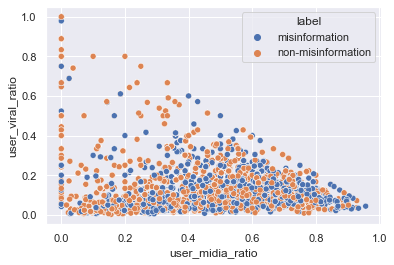

In [33]:
print('relation of viral ratio and midia ratio from the first user who share a viral message')
sns.scatterplot(data=df, x="user_midia_ratio", y="user_viral_ratio", hue="label")

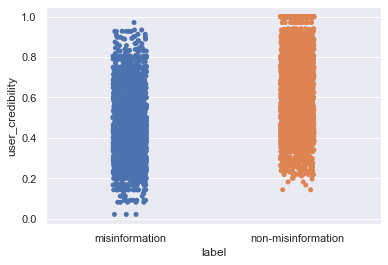

In [34]:
ax = sns.stripplot(x="label", y="user_credibility", data=df)

From this chart we observe that the credibility is not a good indicator to detect misinformation

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


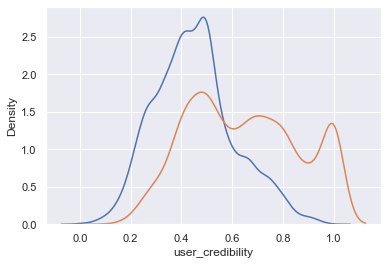

In [35]:
sns.distplot(df[df['label']=='misinformation']['user_credibility'], hist=False, rug=False)
sns.distplot(df[df['label']=='non-misinformation']['user_credibility'], hist=False, rug=False)

plt.show()

# Exploiting user information to detect misinformation

In [36]:
# messages
df_train = pd.read_csv('data/2018/train-test/train.csv')
df_test = pd.read_csv('data/2018/train-test/test.csv')

In [37]:
#df_train['preprocessed_text'] = [preprocess(t) for t in df_train['text']]
#df_test['preprocessed_text'] = [preprocess(t) for t in df_test['text']]

In [38]:
df_users.columns

Index(['id', 'groups', 'number_of_messages', 'texts', 'text_ratio', 'midia',
       'midia_ratio', 'virals', 'viral_ratio', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght', 'misinformation',
       'misinformation_degree_centrality', 'misinformation_strenght',
       'misinformation_ratio', 'viral_misinformation_ratio', 'credibility'],
      dtype='object')

In [39]:
def acquire_user_info(df_target, df_origin):
    viral_ratio = []
    viral_strenght = []
    midia_ratio = []
    
    for m in df_target['text']:
        user_info = df_origin[df_origin['text']==m]
        user_info.sort_values(by='timestamp')
        vr = user_info['user_viral_ratio'].values[0]
        vs = user_info['user_viral_strenght'].values[0]
        mr = user_info['user_midia_ratio'].values[0]
        
        viral_ratio.append(vr)
        viral_strenght.append(vs)
        midia_ratio.append(mr)
    
    df_target['midia_ratio'] = midia_ratio
    df_target['viral_ratio'] = viral_ratio
    df_target['viral_strenght'] = viral_strenght
    
    return df_target

df_train = acquire_user_info(df_train, df)
df_test = acquire_user_info(df_test, df)    

In [40]:
df_train

,text,misinformation,original,id_message,preprocessed_text,midia_ratio,viral_ratio,viral_strenght
0,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,1,0,esquerdo acabar saber que \n stephen kanitz ar...,0.560284,0.177305,1425
1,Leiam esse artigo \n\n\nA ESQUERDA ACABOU. SAI...,1,0,0,ler artigo \n \n \n esquerdo acabar saber que ...,0.394663,0.397472,58364
2,A ESQUERDA ACABOU. SAIBA POR QUÊ?\npor Stephen...,1,0,0,esquerdo acabar saber que ? \n stephen kanitz ...,0.731959,0.142268,6279
3,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0,esquerdo acabar saber que \n stephen kanitz \n...,0.583333,0.250000,159
4,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0,esquerdo acabar saber que \n stephen kanitz \n...,0.619512,0.190244,5772
...,...,...,...,...,...,...,...,...
6228,ATENÇÃO ELEITORES DE BOLSONARO EM BELÉM DO PAR...,0,1,3301,atarncao eleitor bolsonaro belem parar \n \n c...,0.522222,0.255556,2677
6229,"""DITA DURA"".\n\nPara:\n""Ninguém é igual a ning...",1,1,3302,dizer duro \n \n \n ninguem igual ninguem todo...,0.705808,0.121843,29529
6230,GRANDE CARLOS DRUMOND DE ANDRADE: ...,1,0,3302,grande carlos drumond andrade dizer duro \n \n...,0.609195,0.165517,15840
6231,"CARLOS DRUMOND DE ANDRADE\n\nDITA DURA\n""Ningu...",1,0,3302,carlos drumond andrade \n \n dizer duro \n nin...,0.465278,0.175926,7980


In [41]:
# include viral strenght
# X_train = df_train[['midia_ratio','viral_ratio', 'viral_strenght']].to_numpy()
# X_test = df_test[['midia_ratio','viral_ratio', 'viral_strenght']].to_numpy()
# y_train = df_train['misinformation']
# y_test = df_test['misinformation']
# X_train,X_test = utils.z_score(X_train,X_test)
# X_train.shape


X_train = df_train[['midia_ratio','viral_ratio']].to_numpy()
X_test = df_test[['midia_ratio','viral_ratio']].to_numpy()
y_train = df_train['misinformation']
y_test = df_test['misinformation']
X_train.shape

with open('train_user_features.npy', 'wb') as f:
    np.save(f, X_train)
    
with open('test_user_features.npy', 'wb') as f:
    np.save(f, X_test)

logistic regression + user info
0.46
              precision    recall  f1-score   support

           0       0.60      0.40      0.48       834
           1       0.51      0.70      0.59       740

    accuracy                           0.54      1574
   macro avg       0.55      0.55      0.53      1574
weighted avg       0.55      0.54      0.53      1574

AUC:  0.5570994555706786


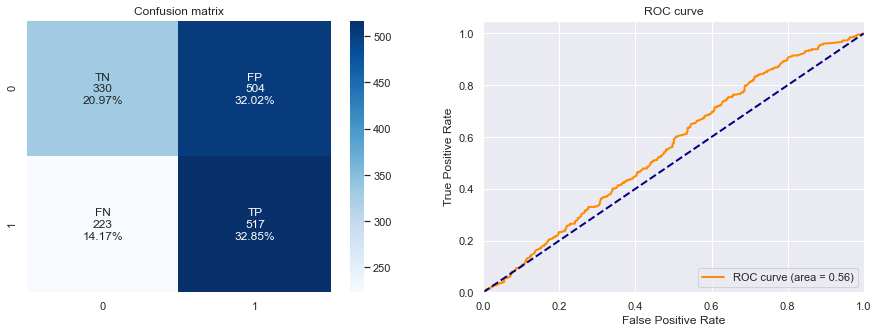

0,538
0,524
0,506
0,698
0,587
0,557


(0.5381194409148666,
 0.5241528478731075,
 0.5063663075416258,
 0.6986486486486486,
 0.5871663827370812,
 0.5570994555706786)

In [42]:
print('logistic regression + user info')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + user
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.518
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.537
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.556
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.572
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.559

--------------------
BEST PARAMETERS (validation AUC = 0.572)
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
--------------------
0.47
              precision    recall  f1-score   support

           0       0.60      0.40      0.48       834
           1       0.51      0.70      0.59       740

    accuracy                           0.54      1574
   macro avg       0.55      0.55      0.53      1574
weighted avg       0.56      0.54      0.53      1574

AUC:  0.5594942964547281


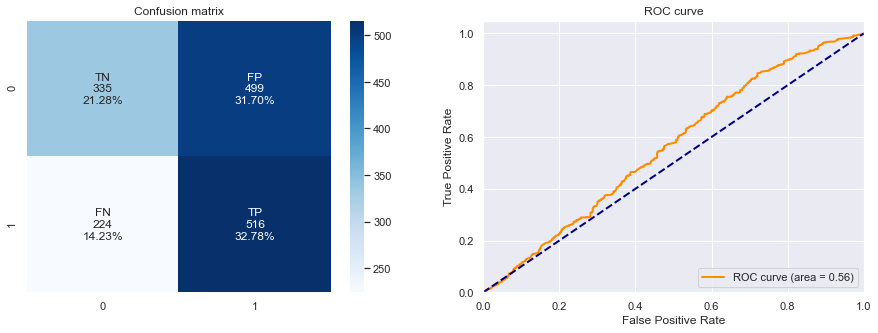

0,540
0,519
0,508
0,697
0,588
0,559


(0.5406607369758577,
 0.5190236898779612,
 0.5083743842364532,
 0.6972972972972973,
 0.588034188034188,
 0.5594942964547281)

In [43]:
print('mlp + user')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=5)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Combining with text

## User + Word2Vec

In [44]:
w2v = Word2Vec.load("data/2018/word2vec.model")
X_train_w = utils.vectorize_corpus(w2v, df_train['preprocessed_text'])
X_test_w = utils.vectorize_corpus(w2v, df_test['preprocessed_text'])
X_train_u = df_train[['midia_ratio','viral_ratio']].to_numpy()
X_test_u = df_test[['midia_ratio','viral_ratio']].to_numpy()

In [45]:
X_train = np.concatenate((X_train_w, X_train_u), axis=1)
X_test = np.concatenate((X_test_w, X_test_u), axis=1)

logistic regression + user info + w2v
0.46
              precision    recall  f1-score   support

           0       0.77      0.70      0.74       834
           1       0.70      0.77      0.73       740

    accuracy                           0.73      1574
   macro avg       0.74      0.74      0.73      1574
weighted avg       0.74      0.73      0.73      1574

AUC:  0.8038029036230475


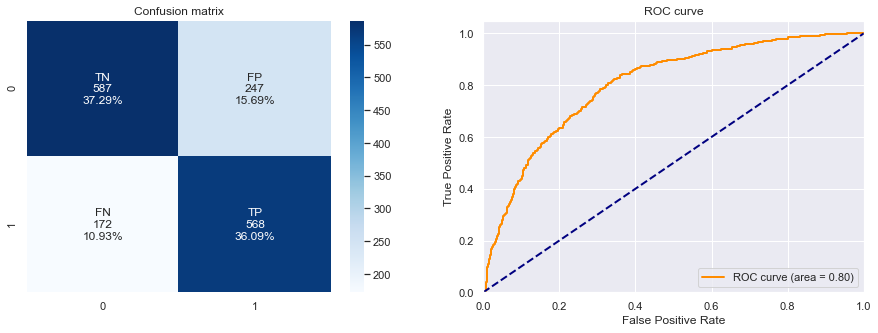

0,733
0,263
0,696
0,767
0,730
0,803


(0.7337992376111817,
 0.26302573760200887,
 0.6969325153374233,
 0.7675675675675676,
 0.7305466237942122,
 0.8038029036230475)

In [46]:
print('logistic regression + user info + w2v')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + user + w2v
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.829
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.777
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.853
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.771
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.790
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
ACC: 0.788
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
ACC: 0.816
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
ACC: 0.819
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
ACC: 0.849
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
ACC: 0.845

--------------------
BEST PARAMETERS (validation AUC = 0.853)
h

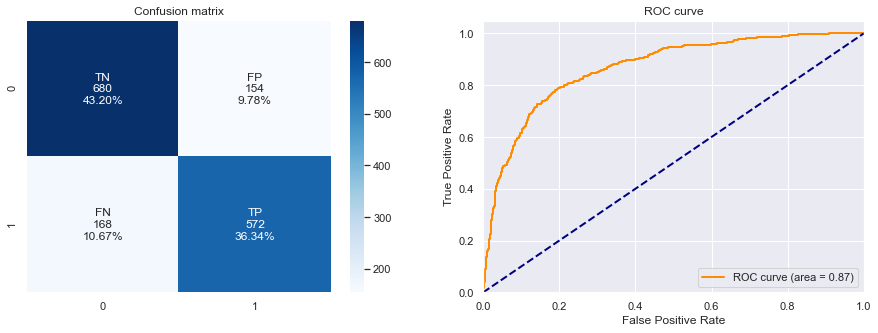

0,795
0,191
0,787
0,772
0,780
0,867


(0.795425667090216,
 0.19143876337693222,
 0.7878787878787878,
 0.772972972972973,
 0.7803547066848568,
 0.8671073951649491)

In [47]:
print('mlp + user + w2v')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=10)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

## TF-IDF + users

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features = 20000, ngram_range = (1,1), #(1,3)  #15000
                             lowercase = False, token_pattern = r'[^\s]+',binary=True)

tfidf.fit(df_train['preprocessed_text'])   
X_train_tfidf = tfidf.transform(df_train['preprocessed_text']).todense()
X_test_tfidf = tfidf.transform(df_test['preprocessed_text']).todense()
X_train_tfidf.shape

(6233, 17525)

In [49]:
X_train = np.concatenate((X_train_tfidf, X_train_u), axis=1)
X_test = np.concatenate((X_test_tfidf, X_test_u), axis=1)

logistic regression + user info + tfidf
0.48
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       834
           1       0.80      0.79      0.79       740

    accuracy                           0.81      1574
   macro avg       0.81      0.81      0.81      1574
weighted avg       0.81      0.81      0.81      1574

AUC:  0.8882980102404563


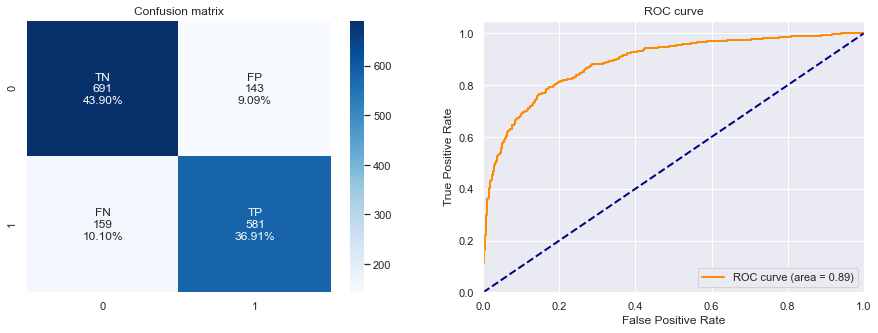

0,808
0,179
0,802
0,785
0,793
0,888


(0.8081321473951716,
 0.17933491686460812,
 0.8024861878453039,
 0.7851351351351351,
 0.7937158469945355,
 0.8882980102404563)

In [50]:
print('logistic regression + user info + tfidf')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + user + tfidf
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.870
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.873
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.872
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.885
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.880
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
ACC: 0.870
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
ACC: 0.888
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
ACC: 0.881
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
ACC: 0.891
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
ACC: 0.856

--------------------
BEST PARAMETERS (validation AUC = 0.891)

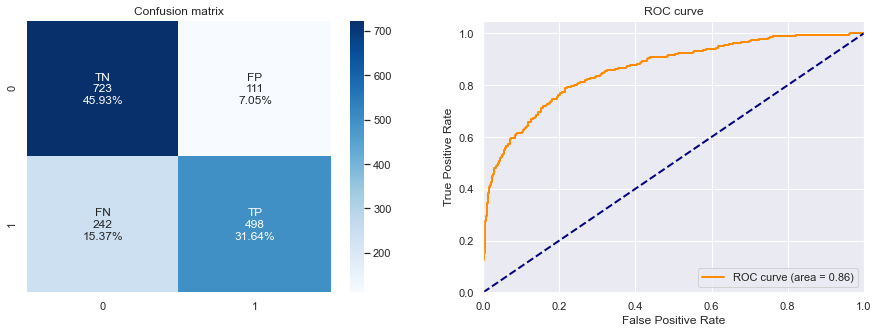

0,775
0,196
0,817
0,672
0,738
0,862


(0.7757306226175349,
 0.19622012229016117,
 0.8177339901477833,
 0.672972972972973,
 0.738324684951816,
 0.8623306759997407)

In [51]:
print('mlp + user + tfidf')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=10)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# First K users

In [52]:
df_full = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df_train = pd.read_csv('data/2018/train-test/train.csv')
df_test = pd.read_csv('data/2018/train-test/test.csv')
df_train['preprocessed_text'] = [preprocess(t) for t in df_train['text']]
df_test['preprocessed_text'] = [preprocess(t) for t in df_test['text']]

print(df_full.columns)
df_full = df_full[df_full['midia']==0]
df_full = df_full[df_full['misinformation']!=-1]
df_full['timestamp'] = df_full.apply(lambda x: custom_time(x['date'],x['hour']),axis=1)
df_full['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df_full.sort_values(by='timestamp',inplace=True)
df_full = df_full[['id','timestamp','text', 'misinformation']]
print(len(df_full))
df_full.head()

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['id', 'date', 'hour', 'timestamp', 'ddi', 'country', 'country_iso3',
       'ddd', 'state', 'group', 'midia', 'url', 'characters', 'words', 'types',
       'viral', 'shares', 'text', 'misinformation'],
      dtype='object')
21289


,id,timestamp,text,misinformation
15,3631133147603888180,2018-08-01 11:08:00,"No dia 07 de Outubro, quando for votar, não es...",1
26,-4391661641377612003,2018-08-01 16:28:00,Devido a aborrecimentos nas varias redes socia...,0
43,3631133147603888180,2018-08-02 17:28:00,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0
73,-4391661641377612003,2018-08-09 17:21:00,"O Brasil que eu quero, é um Brasil com mais FR...",0
95,-4391661641377612003,2018-08-09 22:33:00,Já que a GLOBO não mostra...\n\n*BOLSONARO HOJ...,0


In [53]:
def get_engaged_users(df_target):
    message_id_2_users = {}    
    for m_id in set(df_target['id_message']):
        message_users = []
        messages = df_target[df_target['id_message']==m_id]['text']
        for m in messages:
            message_users.append(df_full[df_full['text']==m])
        
        df_message_users = pd.concat(message_users)
        df_message_users.sort_values(by='timestamp', inplace = True)
        df_message_users.drop_duplicates(subset='id', inplace = True)
        message_id_2_users[m_id] = list(df_message_users['id'])
    
    users_engaged = []
    for m_id in df_target['id_message']:
        users_engaged.append(message_id_2_users[m_id])
    
    df_target['users_engaged'] = users_engaged
    return df_target

df_train = get_engaged_users(df_train)
df_test = get_engaged_users(df_test)

In [54]:
df_train.head(3)

,text,misinformation,original,id_message,preprocessed_text,users_engaged
0,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,1,0,esquerdo acabar saber que \n stephen kanitz ar...,"[-5426274422942733548, 3076210903474883370, -4..."
1,Leiam esse artigo \n\n\nA ESQUERDA ACABOU. SAI...,1,0,0,ler artigo \n \n \n esquerdo acabar saber que ...,"[-5426274422942733548, 3076210903474883370, -4..."
2,A ESQUERDA ACABOU. SAIBA POR QUÊ?\npor Stephen...,1,0,0,esquerdo acabar saber que ? \n stephen kanitz ...,"[-5426274422942733548, 3076210903474883370, -4..."


In [55]:
def get_k_users_info(df_target, k):
    k_features = [[] for i in range(k*2)]
    for users in df_target['users_engaged']:
        users = users[0:k]
        if len(users) < k:
            users += [0]*(k-len(users))
            
        i = 0    
        for u in users:
            if u == 0:
                k_features[i].append(0)
                i+=1
                k_features[i].append(0)
                i+=1
                continue
            
            vr = df_users[df_users['id']==u]['viral_ratio'].values[0]
            k_features[i].append(vr)
            i += 1
            
            mr = df_users[df_users['id']==u]['midia_ratio'].values[0]
            k_features[i].append(mr)
            i += 1
        
    for i in range(0, k*2, 2):
        col_vr = 'viral_ratio' + str(i)
        df_target[col_vr] = k_features[i] 

        col_mr = 'midia_ratio' + str(i+1)
        df_target[col_mr] = k_features[i+1]
        
    return df_target

K = 10 
df_train = get_k_users_info(df_train, K)
df_test = get_k_users_info(df_test, K) 

In [56]:
k = 3
first_user = -K*2
last_user = first_user + k*2
df_train[df_train.columns[first_user:last_user]]

,viral_ratio0,midia_ratio1,viral_ratio2,midia_ratio3,viral_ratio4,midia_ratio5
0,0.397472,0.394663,0.177305,0.560284,0.142268,0.731959
1,0.397472,0.394663,0.177305,0.560284,0.142268,0.731959
2,0.397472,0.394663,0.177305,0.560284,0.142268,0.731959
3,0.397472,0.394663,0.177305,0.560284,0.142268,0.731959
4,0.397472,0.394663,0.177305,0.560284,0.142268,0.731959
...,...,...,...,...,...,...
6228,0.255556,0.522222,0.000000,0.000000,0.000000,0.000000
6229,0.165517,0.609195,0.121843,0.705808,0.041494,0.568465
6230,0.165517,0.609195,0.121843,0.705808,0.041494,0.568465
6231,0.165517,0.609195,0.121843,0.705808,0.041494,0.568465


In [57]:
X_train = df_train[df_train.columns[first_user:last_user]].to_numpy()
X_test = df_test[df_test.columns[first_user:last_user]].to_numpy()
y_train = df_train['misinformation']
y_test = df_test['misinformation']
X_train,X_test = utils.z_score(X_train,X_test)
X_train.shape

(6233, 6)

### Classification

logistic regression + user info
0.53
              precision    recall  f1-score   support

           0       0.64      0.63      0.64       834
           1       0.59      0.61      0.60       740

    accuracy                           0.62      1574
   macro avg       0.62      0.62      0.62      1574
weighted avg       0.62      0.62      0.62      1574

AUC:  0.6495082312528355


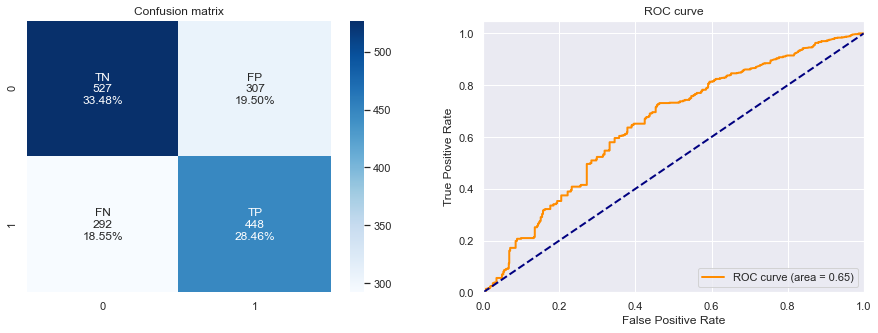

0,619
0,362
0,593
0,605
0,599
0,649


(0.6194409148665819,
 0.36237144585601944,
 0.5933774834437087,
 0.6054054054054054,
 0.5993311036789298,
 0.6495082312528355)

In [58]:
print('logistic regression + user info')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + k user info
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.657
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.633
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.812
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.635
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.721
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
ACC: 0.631
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
ACC: 0.654
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
ACC: 0.716
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
ACC: 0.748
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
ACC: 0.764

--------------------
BEST PARAMETERS (validation AUC = 0.812)


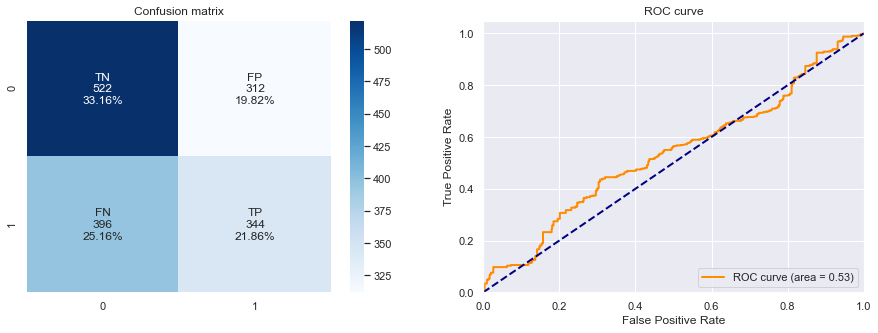

0,550
0,404
0,524
0,464
0,492
0,534


(0.5501905972045743,
 0.40410958904109584,
 0.524390243902439,
 0.4648648648648649,
 0.4928366762177651,
 0.5348378054313306)

In [59]:
print('mlp + k user info')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=10)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

## TF-IDF + k users

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features = 20000, ngram_range = (1,1), #(1,3)  #15000
                             lowercase = False, token_pattern = r'[^\s]+',binary=True)

tfidf.fit(df_train['preprocessed_text'])   
X_train_tfidf = tfidf.transform(df_train['preprocessed_text']).todense()
X_test_tfidf = tfidf.transform(df_test['preprocessed_text']).todense()
X_train_tfidf.shape

(6233, 17527)

In [61]:
X_train_u = df_train[df_train.columns[first_user:last_user]].to_numpy()
X_test_u = df_test[df_test.columns[first_user:last_user]].to_numpy()
X_train_u , X_test_u = utils.z_score(X_train_u, X_test_u)

X_train = np.concatenate((X_train_tfidf, X_train_u), axis=1)
X_test = np.concatenate((X_test_tfidf, X_test_u), axis=1)

logistic regression + k user info + tfidf


C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.46
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       834
           1       0.78      0.80      0.79       740

    accuracy                           0.80      1574
   macro avg       0.80      0.80      0.80      1574
weighted avg       0.80      0.80      0.80      1574

AUC:  0.891556484542096


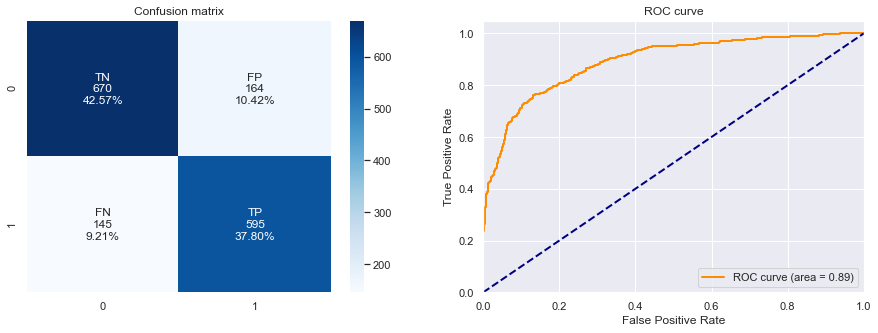

0,803
0,187
0,783
0,804
0,793
0,891


(0.8036848792884371,
 0.1873862947240751,
 0.7839262187088274,
 0.8040540540540541,
 0.7938625750500332,
 0.891556484542096)

In [62]:
print('logistic regression + k user info + tfidf')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + k user info + tfidf
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.867
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.878
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.872
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.889
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.875
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
ACC: 0.849
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
ACC: 0.888
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
ACC: 0.875
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
ACC: 0.894
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
ACC: 0.872

--------------------
BEST PARAMETERS (validation AUC =

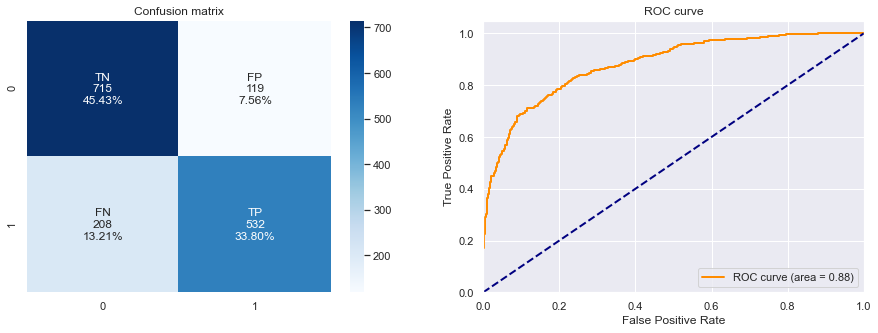

0,792
0,186
0,817
0,718
0,764
0,880


(0.7922490470139771,
 0.18611269208878767,
 0.8172043010752689,
 0.7189189189189189,
 0.7649173256649893,
 0.8809141875688637)

In [63]:
print('mlp + k user info + tfidf')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=10)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)